AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

📥 Загружаем so_questions.csv и преобразуем…
✓ Размер датафрейма после очистки: (119403, 16)

=== Описательная статистика ===
           score  view_count  log_views  answer_count  comment_count  \
count  119403.00   119403.00  119403.00     119403.00      119403.00   
mean        0.24      186.77       4.49          0.94           1.77   
std         1.35      819.12       1.03          0.90           2.36   
min       -12.00        3.00       1.39          0.00           0.00   
25%         0.00       41.00       3.74          0.00           0.00   
50%         0.00       72.00       4.29          1.00           1.00   
75%         1.00      164.00       5.11          1.00           3.00   
max       122.00   113221.00      11.64         12.00          35.00   

       score_per_view  
count       119403.00  
mean             0.05  
std              0.23  
min             -2.53  
25%              0.00  
50%              0.00  
75%              0.15  
max             11.66  


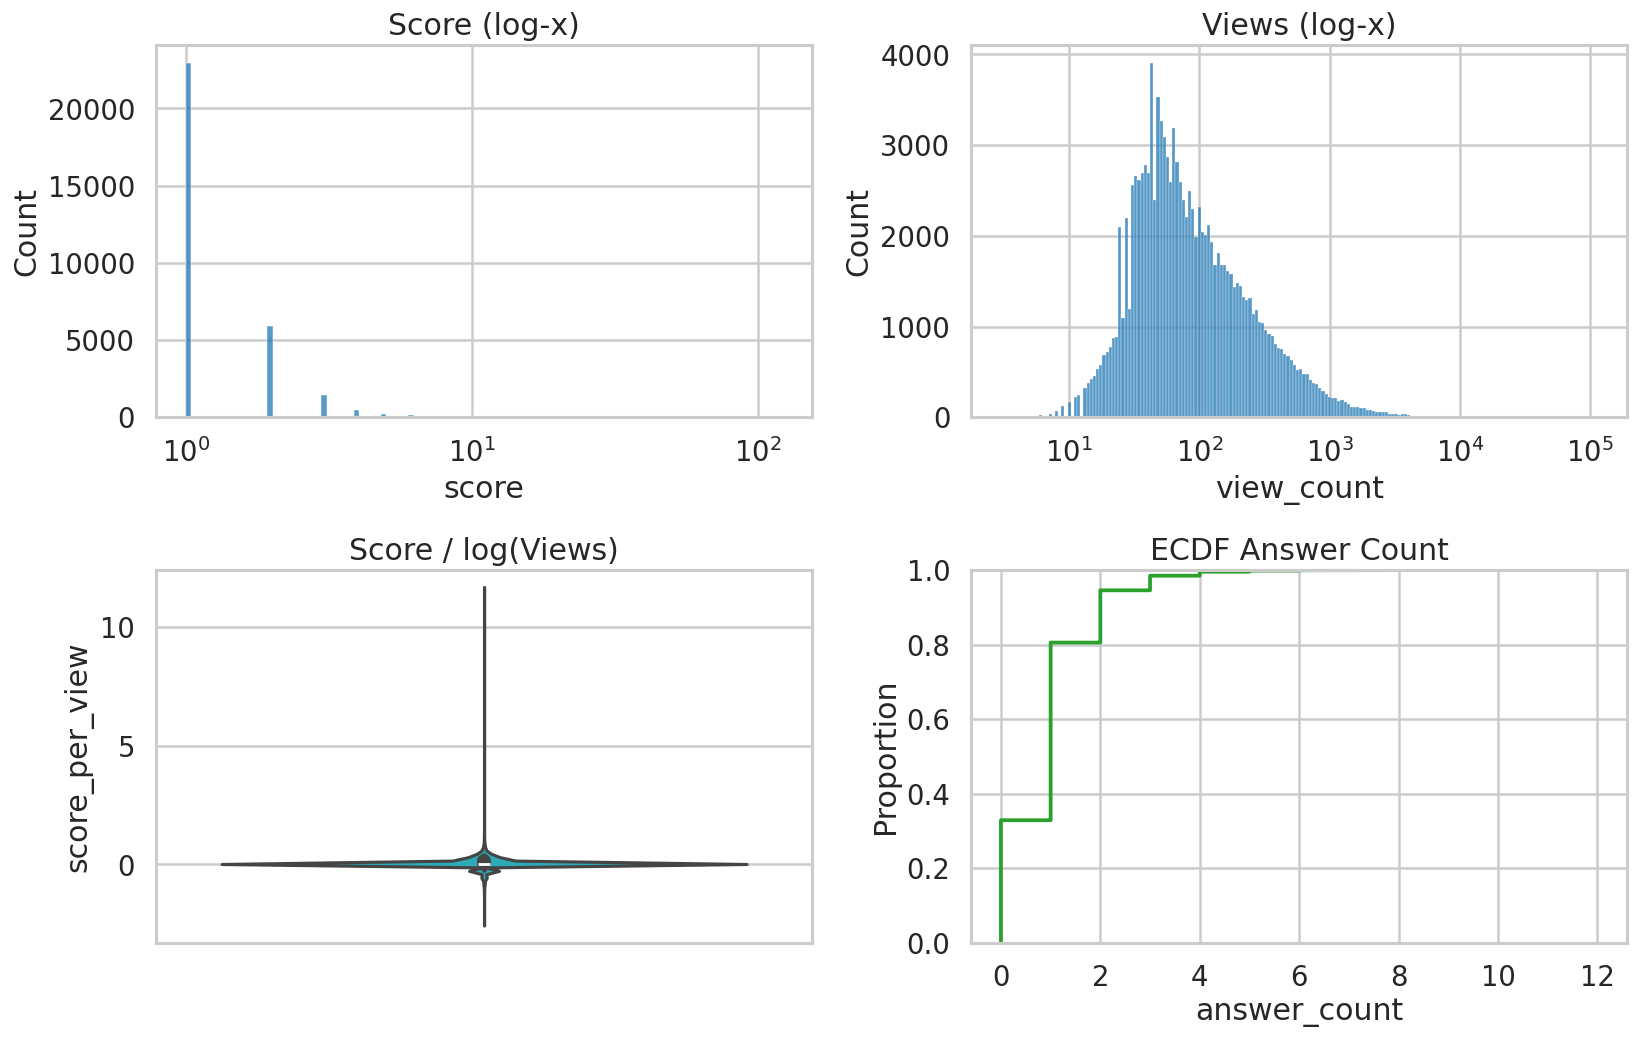


🔗 Корреляции и зависимости…


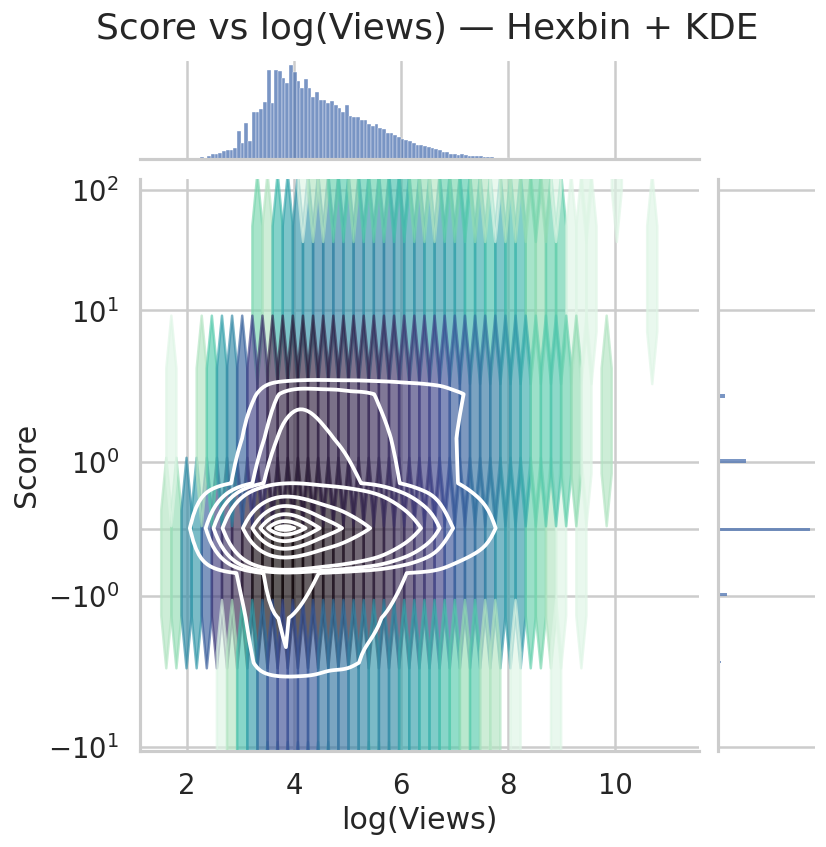

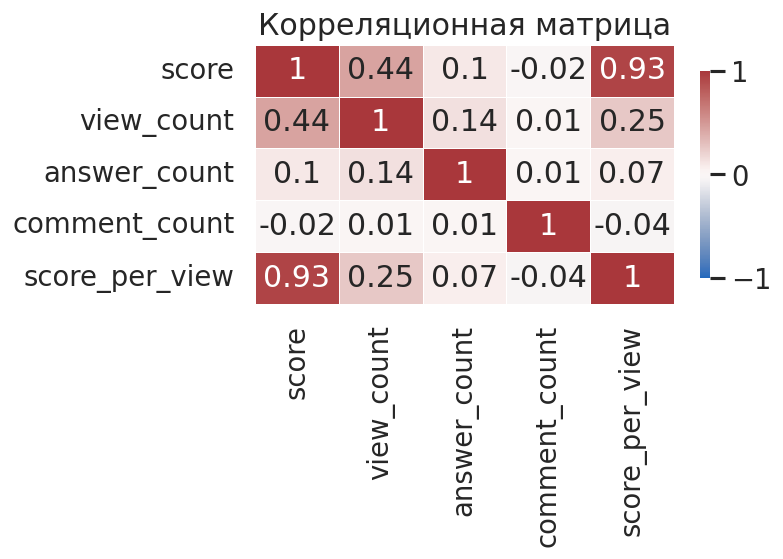

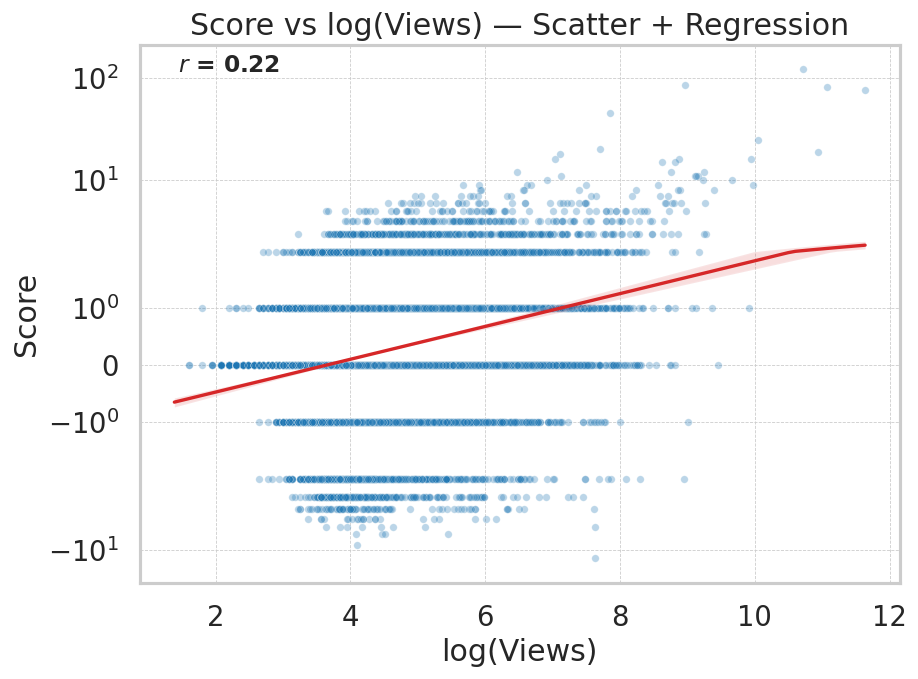

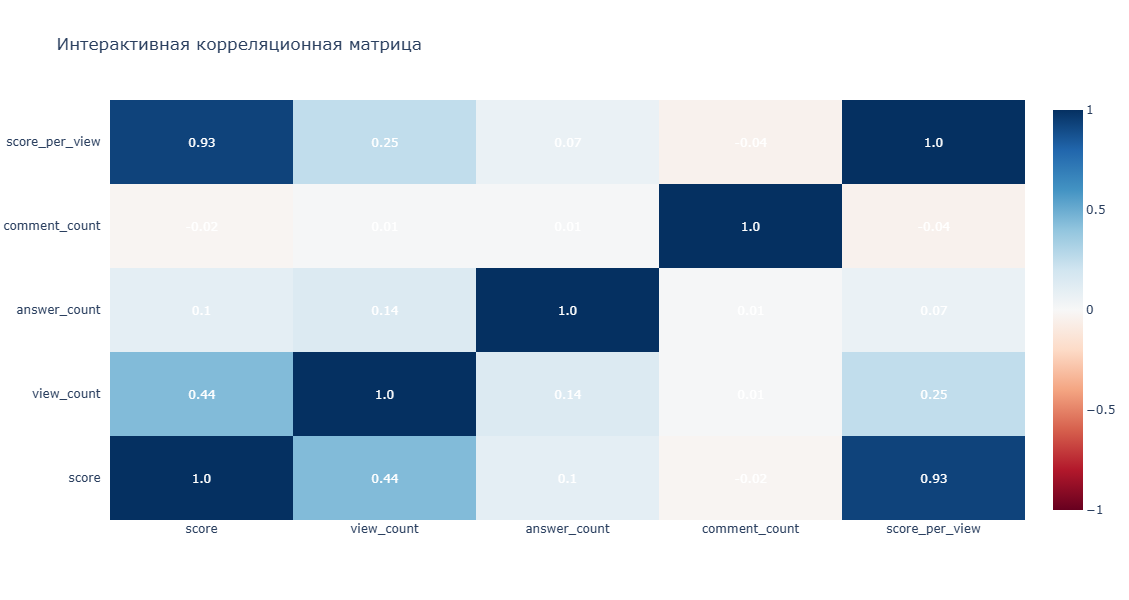

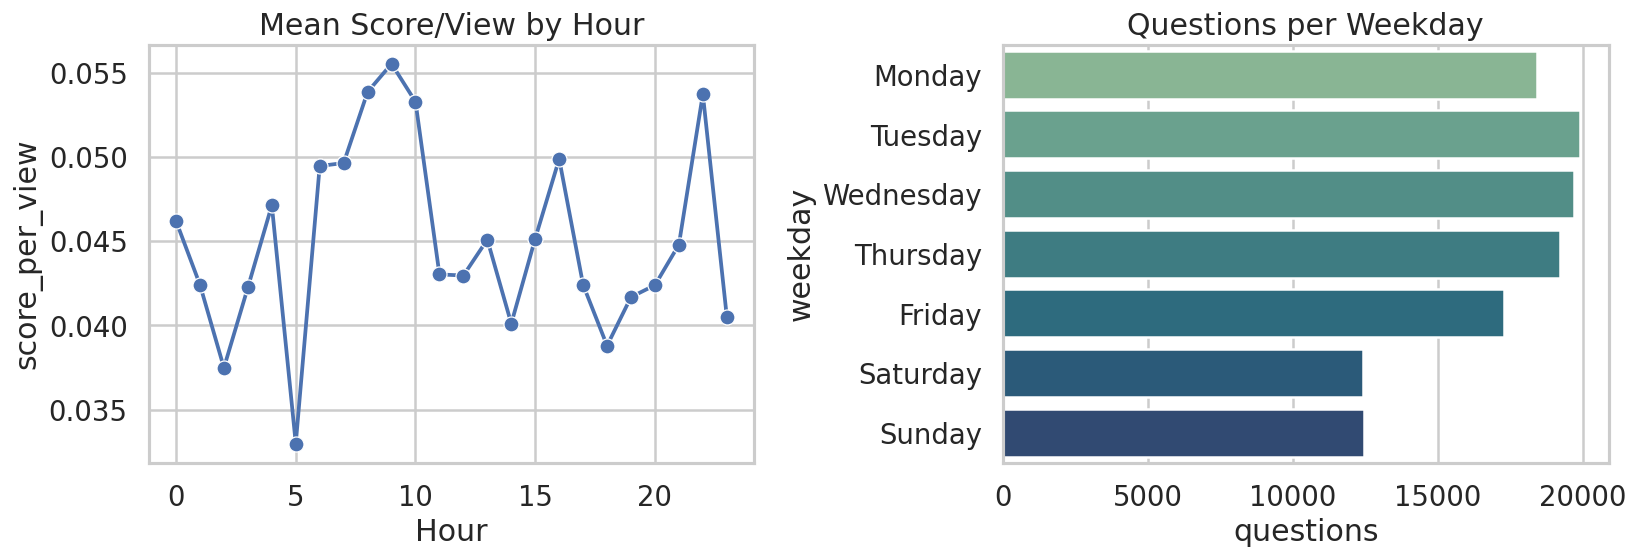

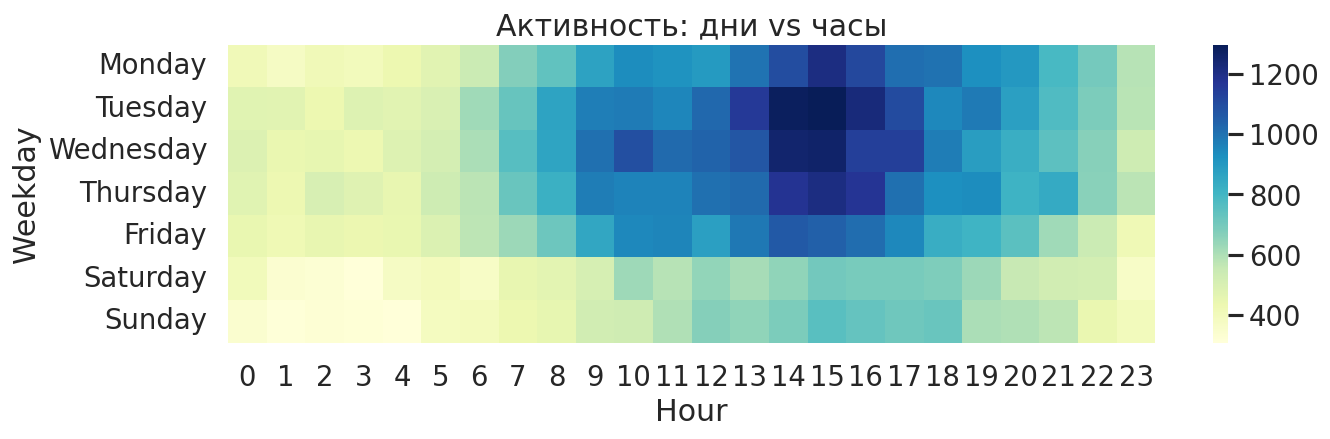


📊 Топ-15 сочетаний тегов:


,Pair,Count
0,pandas + python,17528
1,python + python-3.x,8986
2,dataframe + python,8345
3,dataframe + pandas,7130
4,django + python,6330
5,numpy + python,4878
6,list + python,3638
7,matplotlib + python,3281
8,python + tensorflow,3086
9,python + selenium,2905



🚀 Строим UMAP-embedding тегов…
⚡️ Рисуем интерактивную версию (Plotly)…


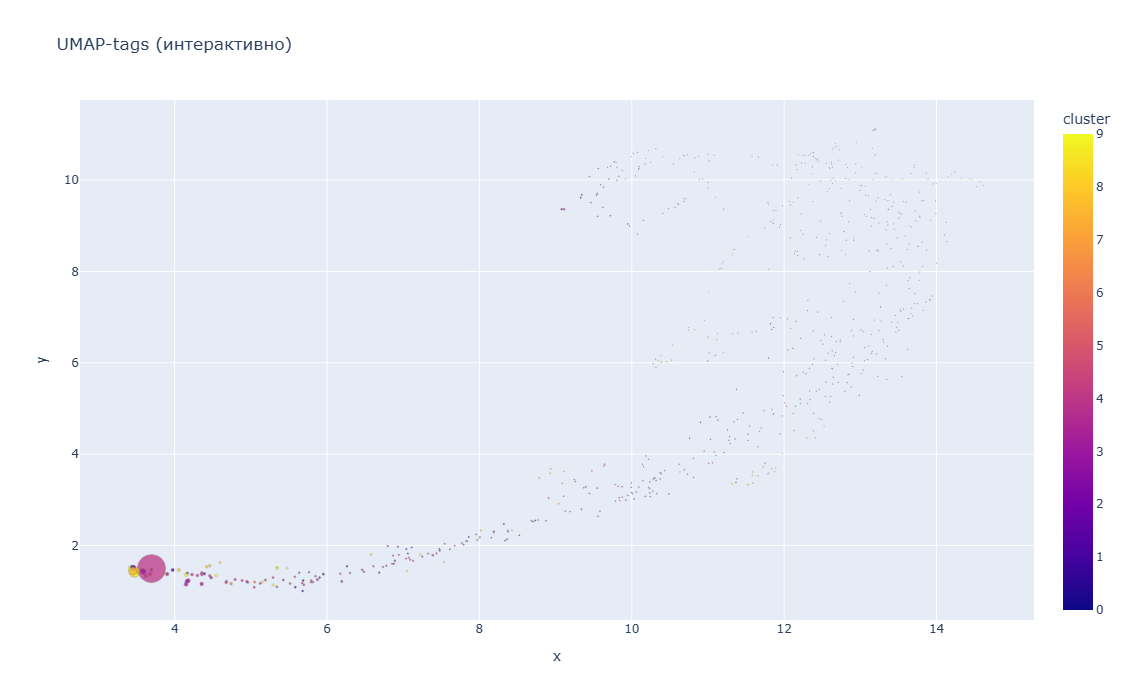

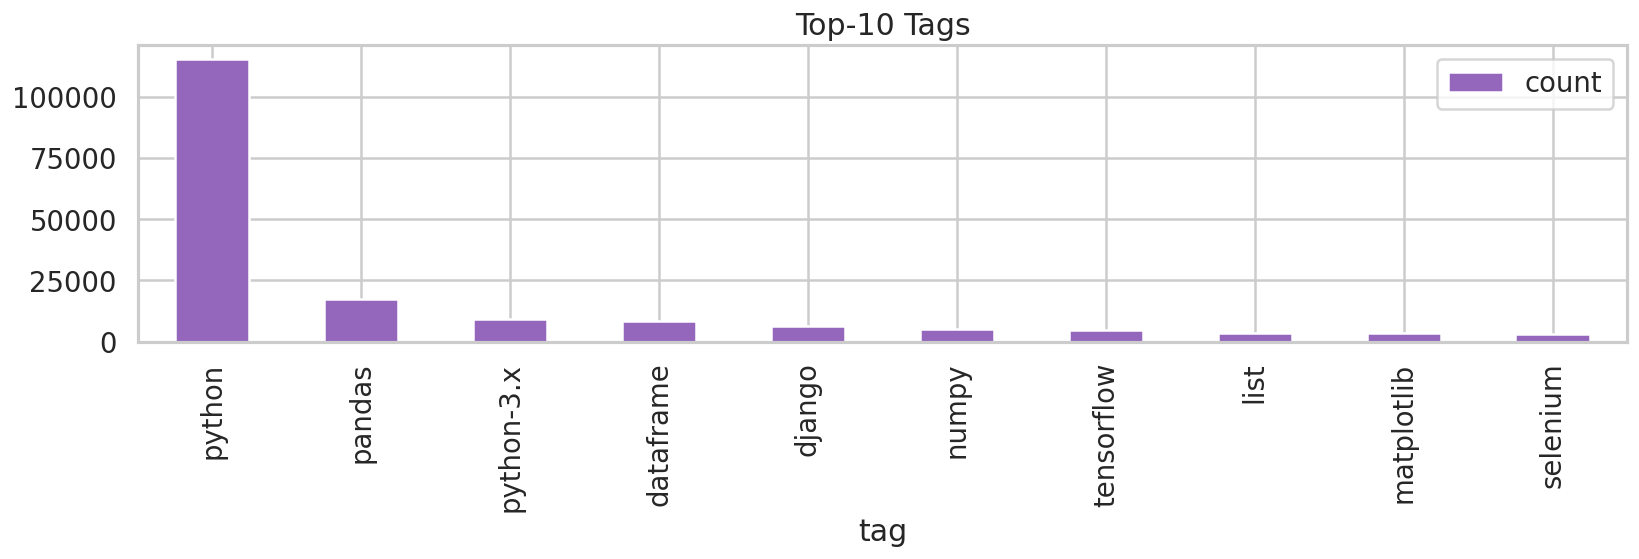

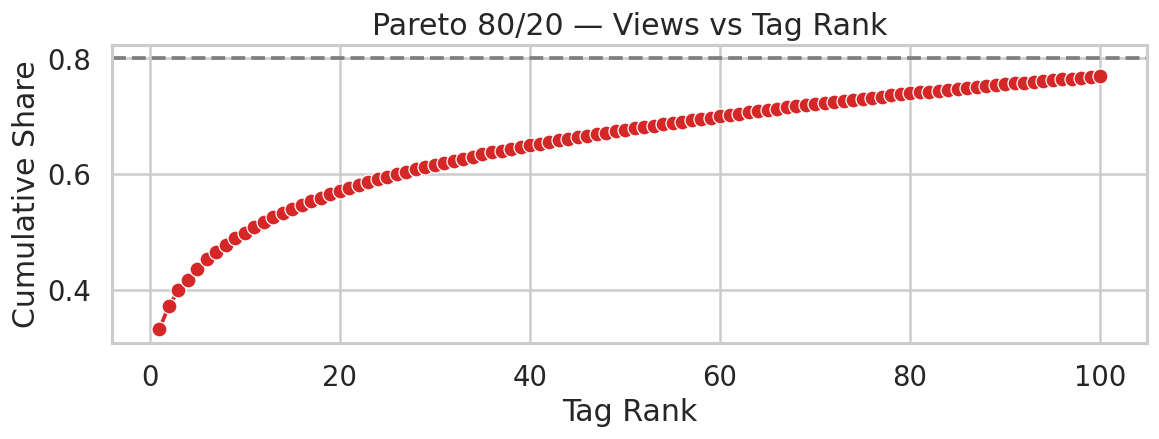

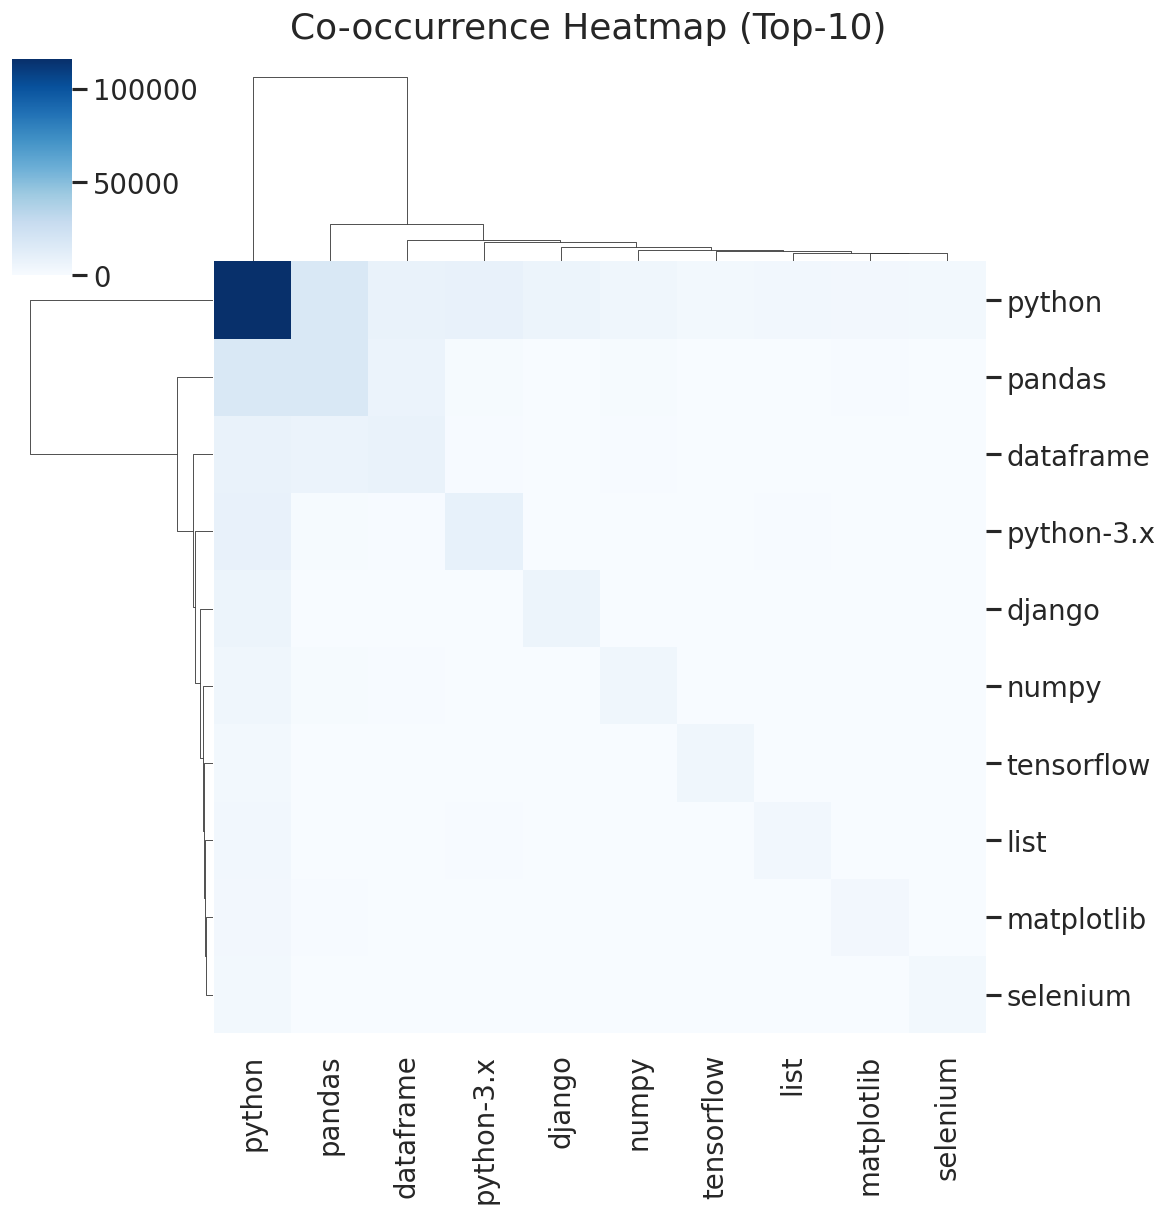

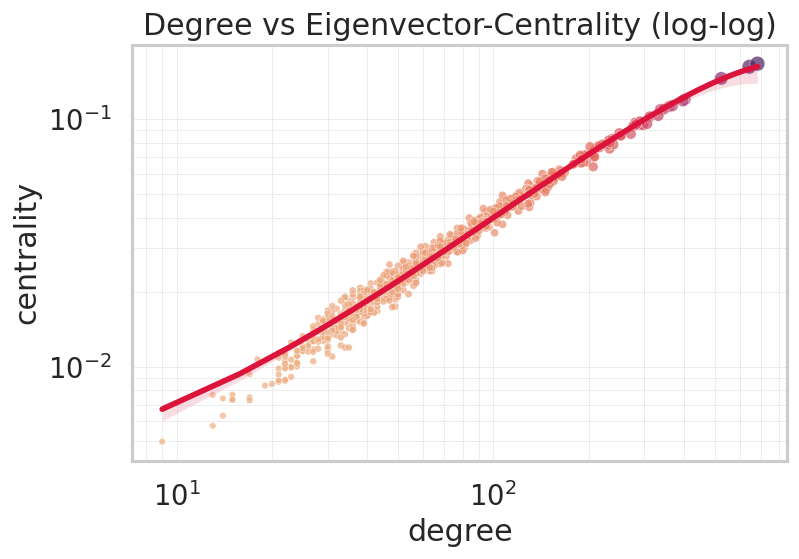

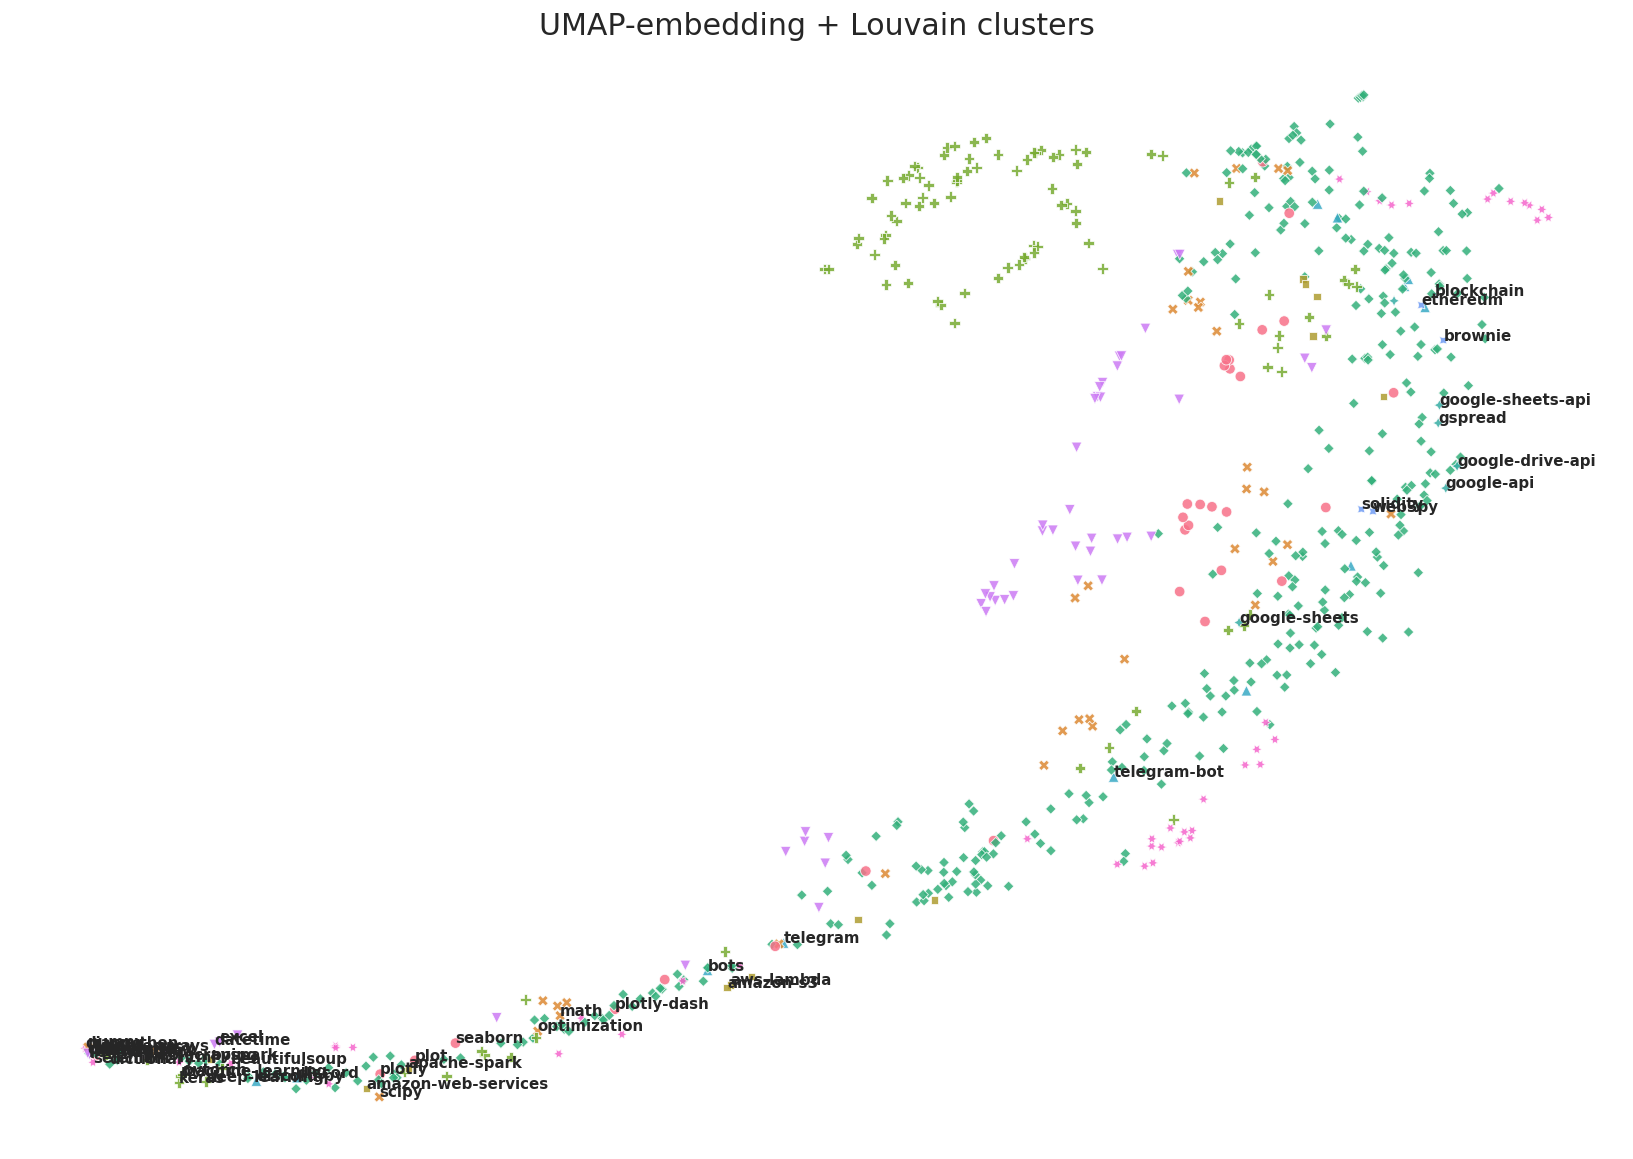

In [1]:
# ════════════════════════════════════════════════════════════════
# 0. ИМПОРТЫ И ГЛОБАЛЬНЫЙ СТИЛЬ
# ════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import ast, warnings, matplotlib.dates as mdates
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import umap                      # → pip install umap-learn
import community as community_louvain  # → pip install python-louvain
import plotly.express as px

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.family"] = "DejaVu Sans"

# ════════════════════════════════════════════════════════════════
# 1. ЗАГРУЗКА ДАННЫХ + ПРЕПРОЦЕССИНГ
# ════════════════════════════════════════════════════════════════
print("📥 Загружаем so_questions.csv и преобразуем…")

df = (pd.read_csv("so_questions.csv")
        .assign(tags_filtered=lambda d: d['tags_filtered'].apply(ast.literal_eval)))

df['creation_date'] = pd.to_datetime(df['creation_date'], utc=True, errors='coerce')
df = df.dropna(subset=['creation_date'])

# Базовые фичи
df['log_views']      = np.log1p(df['view_count'])
df['score_per_view'] = df['score'] / df['log_views'].replace(0, np.nan)
df['num_tags']       = df['tags_filtered'].apply(len)
df['year_month']     = df['creation_date'].dt.to_period("M")
df['year_month_dt']  = df['year_month'].dt.to_timestamp()
df['hour']           = df['creation_date'].dt.hour
df['weekday']        = df['creation_date'].dt.day_name()

print("✓ Размер датафрейма после очистки:", df.shape)

# ════════════════════════════════════════════════════════════════
# 2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА
# ════════════════════════════════════════════════════════════════
print("\n=== Описательная статистика ===")
print(df[['score', 'view_count', 'log_views',
          'answer_count', 'comment_count', 'score_per_view']].describe().round(2))

# ════════════════════════════════════════════════════════════════
# 3. РАСПРЕДЕЛЕНИЯ
# ════════════════════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

def _log_hist(series, ax, title):
    sns.histplot(series, log_scale=True, ax=ax, color='tab:blue')
    ax.set_title(title); ax.set_xlabel(series.name)

_log_hist(df['score'],       axes[0,0], "Score (log-x)")
_log_hist(df['view_count'],  axes[0,1], "Views (log-x)")
sns.violinplot(y=df['score_per_view'], ax=axes[1,0], color='tab:cyan')
axes[1,0].set_title("Score / log(Views)")
sns.ecdfplot(df['answer_count'], ax=axes[1,1], color='tab:green')
axes[1,1].set_title("ECDF Answer Count")

plt.tight_layout(); plt.show()

# ════════════════════════════════════════════════════════════════
# 4. SCORE vs LOG(VIEWS) + КОРРЕЛЯЦИОННАЯ МАТРИЦА
# ════════════════════════════════════════════════════════════════
print("\n🔗 Корреляции и зависимости…")
# 4.1 Hex-joint c KDE и лог-осью Y
g = sns.jointplot(
    data=df.sample(60000, random_state=42),
    x='log_views', y='score',
    kind='hex', bins='log', cmap='mako_r', alpha=.65, height=7)
g.plot_joint(sns.kdeplot, color='white', lw=.8)
g.ax_joint.set_yscale('symlog')
g.set_axis_labels("log(Views)", "Score")
g.fig.suptitle("Score vs log(Views) — Hexbin + KDE", y=1.02)

# 4.2 Корр-матрица
plt.figure(figsize=(7,5))
df_corr = df[['score','view_count','answer_count',
              'comment_count','score_per_view']].corr().round(2)
sns.heatmap(df_corr, annot=True, cmap='vlag', vmin=-1, vmax=1,
            linewidths=.5, cbar_kws={"shrink":.8})
plt.title("Корреляционная матрица"); plt.tight_layout(); plt.show()

import scipy.stats as st

# 1. Рассчитываем коэффициент корреляции
r, p = st.pearsonr(df['log_views'], df['score'])

# 2. Строим scatter + линейная регрессия
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df.sample(30000, random_state=1),
    x='log_views', y='score',
    alpha=0.3, s=20, color='tab:blue'
)
sns.regplot(
    data=df, x='log_views', y='score',
    scatter=False, color='tab:red', line_kws={'lw':2}
)

# 3. Аннотация r
plt.text(
    0.05, 0.95,
    f"$r$ = {r:.2f}",
    transform=plt.gca().transAxes,
    fontsize=14, fontweight='bold'
)

plt.yscale('symlog')
plt.xlabel("log(Views)")
plt.ylabel("Score")
plt.title("Score vs log(Views) — Scatter + Regression")
plt.grid(which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

import plotly.figure_factory as ff

# Готовим матрицу
corr = df[['score','view_count','answer_count','comment_count','score_per_view']].corr().round(2)

# Строим интерактивную тепловую карту
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.values,
    colorscale='RdBu', zmin=-1, zmax=1,
    showscale=True
)

fig.update_layout(
    title="Интерактивная корреляционная матрица",
    xaxis_side="bottom",
    width=600, height=600
)
fig.show()


# ════════════════════════════════════════════════════════════════
# 5. ВРЕМЕННЫЕ ПАТТЕРНЫ (ЧАС • ДЕНЬ • МЕСЯЦ • НЕДЕЛЯ)
# ════════════════════════════════════════════════════════════════
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.lineplot(data=df.groupby('hour')['score_per_view'].mean().reset_index(),
             x='hour', y='score_per_view', marker='o', ax=ax[0])
ax[0].set_title("Mean Score/View by Hour"); ax[0].set_xlabel("Hour")

sns.barplot(
    data=(df.groupby('weekday')['id'].count()
            .reindex(['Monday','Tuesday','Wednesday','Thursday',
                      'Friday','Saturday','Sunday'])
            .reset_index(name='questions')),
    x='questions', y='weekday', palette='crest', ax=ax[1])
ax[1].set_title("Questions per Weekday")

plt.tight_layout(); plt.show()

# 5.1 Тренды по месяцам и неделям
plt.figure(figsize=(12,4))
(df.groupby('year_month_dt')['score_per_view']
   .mean().plot(marker='o', lw=2, color='tab:blue'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45); plt.title("Средний Score/View по месяцам"); plt.grid(); plt.tight_layout()

(df.set_index('creation_date')
   .resample('W')['id'].count()
   .plot(title="Weekly Post Count", figsize=(12,4), lw=2, color='tab:orange'))

# Общий «heatmap» активности (день×час)
heatmap = (df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
             .reindex(index=['Monday','Tuesday','Wednesday',
                             'Thursday','Friday','Saturday','Sunday']))
sns.heatmap(heatmap, cmap='YlGnBu')
plt.title("Активность: дни vs часы"); plt.xlabel("Hour"); plt.ylabel("Weekday")
plt.tight_layout(); plt.show()

# ════════════════════════════════════════════════════════════════
# 6. ТЕГИ: ЧАСТОТА, WORDCLOUD, PARETO, CO-OCCUR
# ════════════════════════════════════════════════════════════════
tag_counts = Counter(tag for tags in df['tags_filtered'] for tag in tags)
tag_df = (pd.DataFrame(tag_counts.items(), columns=['tag','count'])
            .sort_values('count', ascending=False))

# 6.1 Бар-плот Top-30
tag_df.head(10).plot.bar(x='tag', y='count', figsize=(14,5), color='tab:purple')
plt.title("Top-10 Tags"); plt.tight_layout()

# 6.2 WordCloud
WordCloud(width=1000, height=400, background_color="white",
          colormap='cubehelix').generate_from_frequencies(tag_counts).to_image()

# 6.3 Pareto по просмотрам
tag_views = (df.explode('tags_filtered')
               .groupby('tags_filtered')['view_count'].sum()
               .sort_values(ascending=False)
               .reset_index())
tag_views['cum_pct'] = tag_views['view_count'].cumsum()/tag_views['view_count'].sum()
plt.figure(figsize=(10,4))
sns.lineplot(x=np.arange(1,101), y=tag_views['cum_pct'].head(100),
             marker='o', color='tab:red')
plt.axhline(.8, ls='--', c='gray'); plt.title("Pareto 80/20 — Views vs Tag Rank")
plt.xlabel("Tag Rank"); plt.ylabel("Cumulative Share"); plt.tight_layout()

# 6.4 Co-occurrence heatmap (Top-50)
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(df['tags_filtered'])
top50 = tag_df.head(10)['tag'].tolist()
co_mat = (pd.DataFrame(tag_matrix, columns=mlb.classes_)[top50]).T.dot(
          pd.DataFrame(tag_matrix, columns=mlb.classes_)[top50])
sns.clustermap(co_mat, cmap='Blues', figsize=(10,10),
               metric='euclidean', method='average')
plt.suptitle("Co-occurrence Heatmap (Top-10)", y=1.02)

# 6.5 Топ-15 пар тегов
pairs = Counter(pair for tags in df['tags_filtered']
                for pair in combinations(sorted(tags), 2))
pair_df = (pd.DataFrame(pairs.most_common(15), columns=['Pair','Count'])
             .assign(Pair=lambda d: d['Pair'].apply(lambda t: ' + '.join(t))))
print("\n📊 Топ-15 сочетаний тегов:"); display(pair_df.style.background_gradient(cmap='Blues'))

# ════════════════════════════════════════════════════════════════
# 7. ГРАФ: DEGREE vs EIGEN-CENTRALITY
# ════════════════════════════════════════════════════════════════
G = nx.read_graphml("so_graph.graphml")
eig_cent = nx.eigenvector_centrality(G)
deg_cent = pd.DataFrame({
    'degree': dict(G.degree()).values(),
    'centrality': [eig_cent[n] for n in G.nodes()]
})

plt.figure(figsize=(7,5))
sns.scatterplot(data=deg_cent, x='degree', y='centrality',
                hue='degree', palette='flare', size='degree',
                sizes=(15,80), alpha=.7, legend=False)
sns.regplot(data=deg_cent, x='degree', y='centrality',
            scatter=False, color='crimson', order=2)
plt.xscale('log'); plt.yscale('log')
plt.grid(which='both', ls='--', lw=.3)
plt.title("Degree vs Eigenvector-Centrality (log-log)")
plt.tight_layout()

# ════════════════════════════════════════════════════════════════
# 8. UMAP-EMBEDDING + LOUVAIN КЛАСТЕРЫ
# ════════════════════════════════════════════════════════════════
print("\n🚀 Строим UMAP-embedding тегов…")
A = nx.to_numpy_array(G)               # матрица смежности
umap_emb = umap.UMAP(random_state=42).fit_transform(A)

embed_df = (pd.DataFrame(umap_emb, columns=['x','y'])
              .assign(tag=list(G.nodes())))
embed_df['freq']    = embed_df['tag'].map(tag_counts).fillna(1)
embed_df['cluster'] = embed_df['tag'].map(community_louvain.best_partition(G))

# время первого появления
first_month = {}
for ym, grp in df.groupby('year_month'):
    for t in {tag for tags in grp['tags_filtered'] for tag in tags}:
        first_month.setdefault(t, ym)
embed_df['time'] = embed_df['tag'].map(first_month).dt.to_timestamp()

palette = sns.husl_palette(embed_df['cluster'].nunique())
plt.figure(figsize=(14,10))
sns.scatterplot(data=embed_df, x='x', y='y',
                hue='cluster', style='cluster',
                palette=palette, s=40, alpha=.85, legend=False)
for cl in embed_df['cluster'].unique():
    top = embed_df.query('cluster==@cl').nlargest(5,'freq')
    for _, r in top.iterrows():
        plt.text(r.x, r.y, r.tag, fontsize=9, weight='bold')
plt.axis('off'); plt.title("UMAP-embedding + Louvain clusters"); plt.tight_layout()

# ════════════════════════════════════════════════════════════════
# 9. PLOTLY: ИНТЕРАКТИВНОЕ ОБЛАКО ТЕГОВ
# ════════════════════════════════════════════════════════════════
print("⚡️ Рисуем интерактивную версию (Plotly)…")
fig = px.scatter(embed_df, x='x', y='y',
                 color='cluster', size='freq',
                 hover_name='tag', hover_data={'freq':True},
                 width=920, height=700,
                 title="UMAP-tags (интерактивно)")
fig.update_traces(marker=dict(opacity=.75,
                              line=dict(width=.4, color='gray')))
fig.update_layout(dragmode='pan', legend_title='Cluster')
fig.show()


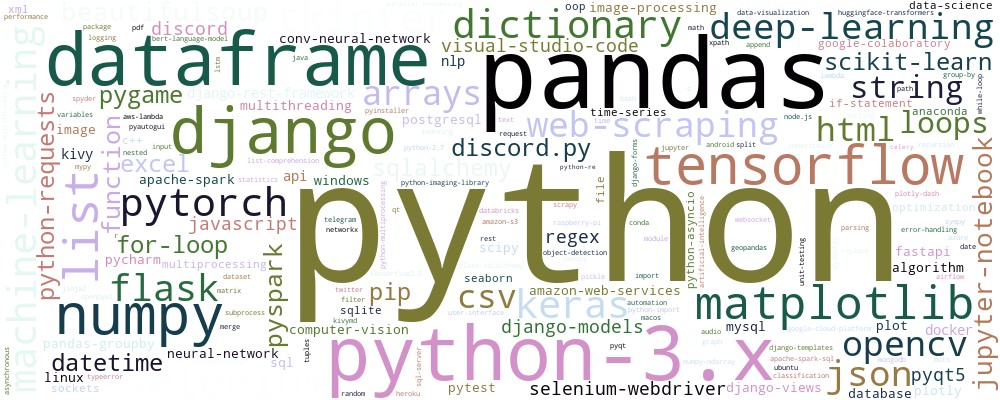

In [2]:
# 6.2 WordCloud
WordCloud(width=1000, height=400, background_color="white",
          colormap='cubehelix').generate_from_frequencies(tag_counts).to_image()

<Axes: xlabel='num_tags'>

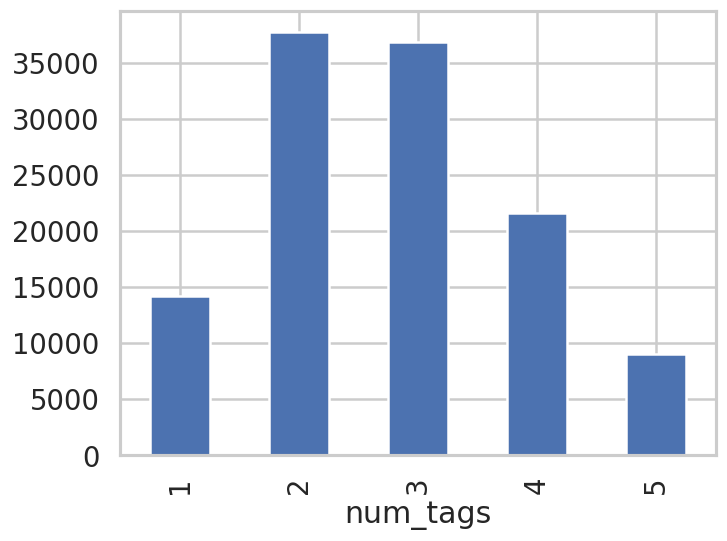

In [3]:
df['num_tags'].value_counts().sort_index().plot.bar()

In [4]:
embed_df.groupby('cluster')['freq'].sum().sort_values(ascending=False).head()


cluster
4    208828
8     36292
3     32438
9     24142
1     12668
Name: freq, dtype: int64

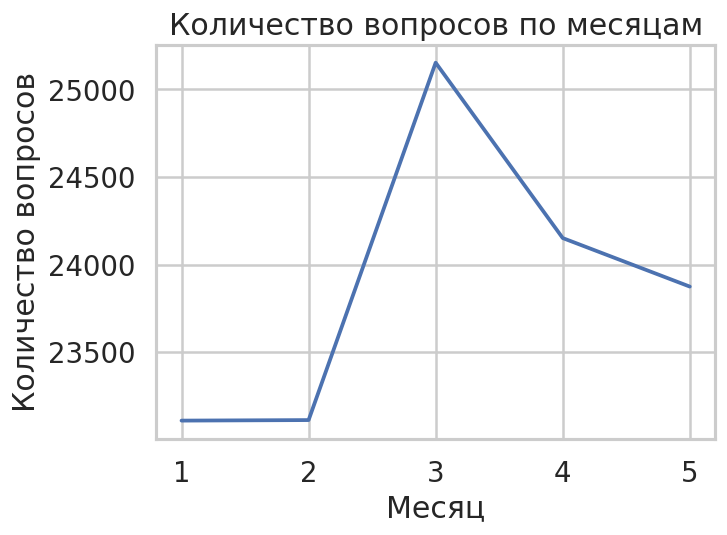

In [5]:
import matplotlib.pyplot as plt

df['month'] = df['creation_date'].dt.month

# Группировка: подсчет числа вопросов по месяцам
counts = df.groupby('month').size().sort_index()

plt.figure()
plt.plot(counts.index, counts.values)
plt.xlabel('Месяц')
plt.ylabel('Количество вопросов')
plt.title('Количество вопросов по месяцам')
plt.xticks(counts.index)
plt.tight_layout()
plt.show()


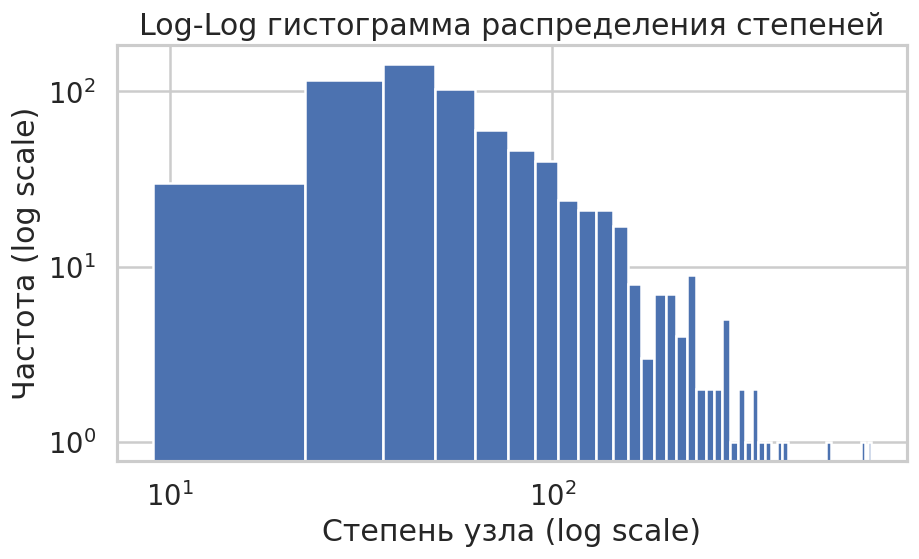

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Предположим, что ваш граф называется G
# Собираем список степеней всех узлов
degree_sequence = [deg for _, deg in G.degree()]

# Рисуем гистограмму
plt.figure(figsize=(8, 5))
plt.hist(degree_sequence, bins=50)     # 50 корзин можно скорректировать
plt.xscale('log')                      # логарифмический масштаб по оси X
plt.yscale('log')                      # логарифмический масштаб по оси Y
plt.xlabel('Степень узла (log scale)')
plt.ylabel('Частота (log scale)')
plt.title('Log-Log гистограмма распределения степеней')
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import networkx as nx
from IPython.display import display

# Предположим, что ваш граф называется G и уже загружен в память

# Расчёт центральностей
degree_dict = dict(G.degree())
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
betweenness_dict = nx.betweenness_centrality(G)

# Формирование DataFrame
df_centrality = pd.DataFrame({
    'degree': pd.Series(degree_dict),
    'eigenvector': pd.Series(eigenvector_dict),
    'betweenness': pd.Series(betweenness_dict)
})
df_centrality = df_centrality.sort_values('degree', ascending=False)

# Вывод таблицы
display(df_centrality)


,degree,eigenvector,betweenness
python,683,0.167550,0.121035
python-3.x,644,0.162830,0.095678
pandas,525,0.146165,0.046833
numpy,403,0.120109,0.023100
dataframe,397,0.118737,0.021264
...,...,...,...
django-urls,14,0.007428,0.000003
tensorflow-federated,14,0.006325,0.000008
ethereum,13,0.005760,0.000011
ursina,13,0.007674,0.000005


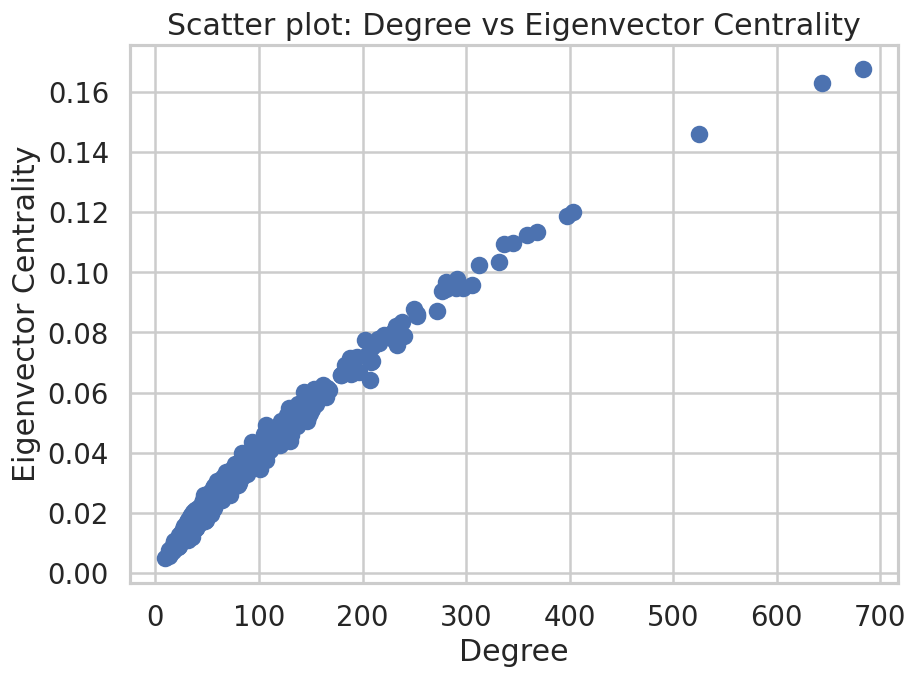

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Предположим, что ваш граф называется G и уже загружен в память
# Расчёт степени и собственно-векторной центральности
degree_dict = dict(G.degree())
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

# Подготовка списков для осей
degrees = [degree_dict[node] for node in G.nodes()]
eigenvectors = [eigenvector_dict[node] for node in G.nodes()]

# Построение scatter-графика
plt.figure(figsize=(8, 6))
plt.scatter(degrees, eigenvectors)
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.title('Scatter plot: Degree vs Eigenvector Centrality')
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import networkx as nx

# После создания графа G
degree_dict = dict(G.degree())
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
betweenness_dict = nx.betweenness_centrality(G)

df_centrality = pd.DataFrame({
    'degree': pd.Series(degree_dict),
    'eigenvector': pd.Series(eigenvector_dict),
    'betweenness': pd.Series(betweenness_dict)
})
df_centrality = df_centrality.sort_values('degree', ascending=False)


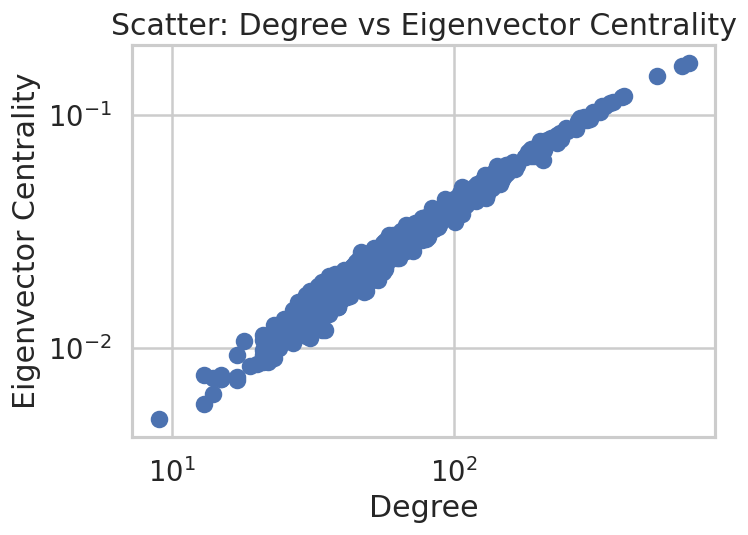

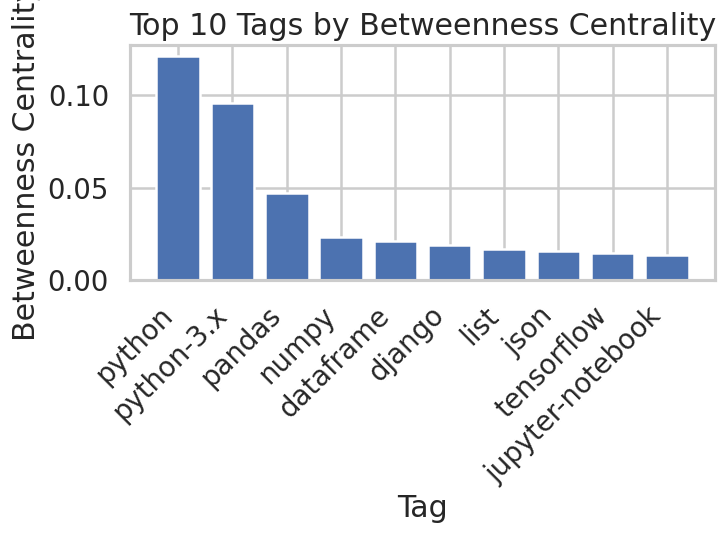

In [19]:
import matplotlib.pyplot as plt

# Предполагается, что у вас уже есть DataFrame df_centrality с индексом-тегами 
# и колонками ['degree', 'eigenvector', 'betweenness']

# 1) Scatter plot: degree vs eigenvector centrality
plt.figure()
plt.scatter(df_centrality['degree'], df_centrality['eigenvector'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.title('Scatter: Degree vs Eigenvector Centrality')
plt.tight_layout()

# 2) Bar chart: Top 10 tags by betweenness centrality
top_betweenness = df_centrality['betweenness'].sort_values(ascending=False).head(10)
plt.figure()
plt.bar(top_betweenness.index, top_betweenness.values)
plt.xlabel('Tag')
plt.ylabel('Betweenness Centrality')
plt.title('Top 10 Tags by Betweenness Centrality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [21]:
# 2. Инженерия признаков
df['engagement_score'] = df['view_count'] + 5 * df['score'] + 10 * df['answer_count'] + 2 * df['comment_count']
df['text_length_words'] = df['full_text'].str.split().str.len()
df['code_block_count'] = df['full_text'].str.count(r'```') / 2
df['tags_count'] = df['tags_filtered'].apply(len)
# Циклическое кодирование времени
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_num'] = df['day_of_week'].map({day: i for i, day in enumerate(days)})
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)

# 3. Подготовка матрицы признаков
features = [
    'engagement_score', 'text_length_words', 'code_block_count',
    'tags_count', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Метод "локтя" для выбора числа кластеров
wcss = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
plt.figure()
plt.plot(range(2, 9), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# 5. Силуэт-анализ
sil = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))
plt.figure()
plt.plot(range(2, 9), sil, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# 6. Финальная кластеризация (K=4)
k = 4
km_final = KMeans(n_clusters=k, random_state=42)
labels = km_final.fit_predict(X_scaled)
df['cluster'] = labels

# 7. UMAP-проекция кластеров
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Clusters')
plt.show()

# 8. Радарный график профилей кластеров
cluster_profiles = df.groupby('cluster')[features].mean()
labels_radar = [
    'Engagement', 'TextLen', 'CodeBlocks', 'TagsCount',
    'HourSin', 'HourCos', 'DaySin', 'DayCos'
]
angles = np.linspace(0, 2 * math.pi, len(labels_radar), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure()
ax = plt.subplot(111, polar=True)
for idx in cluster_profiles.index:
    vals = cluster_profiles.loc[idx].values
    vals = np.concatenate((vals, [vals[0]]))
    ax.plot(angles, vals, label=f'Cluster {idx}')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels_radar)
ax.set_title('Cluster Profiles Radar Chart')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

KeyError: 'day_of_week'